# Problem 2.2 (a)

(Potato in space) What is the equilibrium shape of a $0.0042\,\mathrm{\mu m}^3$ volume of $\mathrm{Al_2SiO_5}$ in free space (stress-free boundaries)? Take the surface energy, $\gamma$, to be equal to $200\,\mathrm{mJ/m^2}$. The crystalline axes a, b, and c are aligned with the x, y, and z-axes of a Cartesian lab coordinate system.

Iterative FFT stress calculation method of

> A PHASE-FIELD MODEL FOR EVOLVING MICROSTRUCTURES WITH STRONG ELASTIC INHOMOGENEITY  
> S. Y. HU and L. Q. CHEN  
> _Acta mater._ **49** (2001) 1879–1890

In [1]:
%matplotlib inline

In [2]:
import fipy as fp

In [3]:
from fipy import numerix as nmx

The interface width W between approximately $\varphi = 0.1$ and $\varphi = 0.9$ in this model is given by $W = 2\sqrt{2\kappa/h_0}$, while $\gamma = \sqrt{\kappa h_0/18}$, $\kappa = 1.5\gamma W$, and $h_0 = 12\gamma/W$ (ignoring modification of the phase field order parameter $\varphi$ by the elastic interactions through the interface). Use $\kappa = 3\times 10^{-9}\,\mathrm{J/m}$, and $h_0 = 2.4\times 10^{8}\,\mathrm{J/m^3}$.

In [4]:
kappa = fp.Variable("3e-9 J/m")

In [5]:
h0 = fp.Variable("2.4e8 J/m**3")

In [6]:
W = 2*nmx.sqrt(2*kappa/h0)

In [7]:
print W

1e-08 m


In [8]:
h0 = h0.value.value
kappa = kappa.value.value

In [84]:
Lx = 40.

In [85]:
dx = Lx / 1000.

In [86]:
mesh = fp.Grid1D(dx=dx, Lx=Lx) + [[-Lx/2.]] #, [-Lx/2.]]

In [93]:
phase = fp.CellVariable(mesh=mesh, name=r"$\varphi$", value=0.) #, hasOld=True)

> The total free energy can be written
$$\mathcal{F} = \int \left[f_\mathrm{elastic} + \frac{\kappa}{2}|\nabla \varphi|^2 + h_0 f(\varphi)\right] dV$$
We use a simple interpolation fo the elastic constants
$$C_{ijkl} = h(\varphi) C_{ijkl}^\mathrm{potato}$$
where $h(\varphi)$ is a smooth interpolation function,
$$h(\varphi) = \varphi^3\left[6\varphi^2 - 15\varphi + 10\right]$$
that interpolates between $h(\varphi=0) = 0$ and $h(\varphi=1) = 1$.

> Hint: Find time-evolution equations for $\varphi$ that monotonically drive the total energy to a minimum while preserving the volume. One way to to this is to set up a Cahn-Hilliard equation for $\varphi$.

Our Cahn-Hilliard evolution equation is given by
$$\frac{\partial \varphi}{\partial t} = \nabla\cdot\left(M_\varphi \nabla\frac{\delta \mathcal{F}}{\delta \varphi}\right)$$
where
$$\begin{align*}
\frac{\delta \mathcal{F}}{\delta \varphi} 
&= \frac{\partial f_\mathrm{elastic}}{\partial\varphi} - \kappa \nabla^2 \varphi + h_0 \frac{\partial f(\varphi)}{\partial\varphi} \\
&= \frac{\partial f_\mathrm{elastic}}{\partial\varphi} - \kappa \nabla^2 \varphi + h_0 \frac{\partial}{\partial\varphi}\left[\varphi^2\left(\varphi - 1\right)^2\right] \\
&= \frac{\partial f_\mathrm{elastic}}{\partial\varphi} - \kappa \nabla^2 \varphi + 2 h_0 \varphi\left(\varphi - 1\right)\left(2\varphi - 1\right)
\end{align*}$$
such that
$$
\begin{align*}
\frac{\partial \varphi}{\partial t} 
&= \nabla\cdot\left(M_\varphi \left\{
\nabla \frac{\partial f_\mathrm{elastic}}{\partial\varphi} + 2 h_0 \left[1 + 6\varphi\left(\varphi - 1\right)\right]\nabla \varphi
- \kappa \nabla^3 \varphi\right\}\right) \\
\frac{1}{M_\varphi}\frac{\partial \varphi}{\partial t} 
&= \nabla^2 \frac{\partial f_\mathrm{elastic}}{\partial\varphi}
+ \nabla\cdot\left\{2 h_0 \left[1 + 6\varphi\left(\varphi - 1\right)\right]\right\}\nabla \varphi
- \kappa \nabla^4 \varphi
\end{align*}$$

Let $M_\mathrm{\varphi} = 1$

In [94]:
Mphase = 1.

Let's ignore the elastic energy for now
$$
\begin{align*}
\frac{1}{M_\varphi}\frac{\partial \varphi}{\partial t} 
&= \nabla\cdot\left\{2 h_0 \left[1 + 6\varphi\left(\varphi - 1\right)\right]\right\}\nabla \varphi
- \kappa \nabla^4 \varphi
\end{align*}$$

In [95]:
PHASE = phase.faceValue

In [96]:
h0=1./2

In [97]:
kappa=1.

In [98]:
phaseEq = (fp.TransientTerm(coeff=1./Mphase) 
           == fp.DiffusionTerm(coeff=2 * h0 * (1 + 6 * PHASE * (PHASE - 1))) 
           - fp.DiffusionTerm(coeff=(1., kappa)))

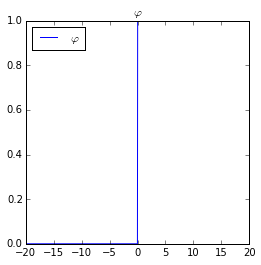

In [101]:
viewer = fp.Viewer(vars=phase, datamin=0., datamax=1.)

In [100]:
phase.value = 0.
phase.setValue(1., where=mesh.x > 0.)

In [102]:
viewer.plot()
for step in xrange(1000000):
    print phase.cellVolumeAverage
    
#    phase.updateOld()
    phaseEq.solve(var=phase, dt=1.e-10)
    viewer.plot()

KeyboardInterrupt: 

In [97]:
print min(phase), max(phase)

0.128020410652 0.128020410962
